# Análises para Clusterização

In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans


In [2]:
FILE_PATH = './cluster-results/merged_data.tsv'

df = pd.read_csv(FILE_PATH, sep='\t')
dropped_df = df.drop(columns=['user', 'group', 'timestamp', 'index'])
df.head(10)

,index,MI_max,MI_super_max,MI_super_avg,user,group,timestamp
0,0,0.000,0.000,0.000,561401894,561401894--1001034598292,1.544316e+09
1,1,1.127,0.067,0.066,561401894,561401894--1001034598292,1.551133e+09
2,2,1.529,0.078,0.071,561401894,561401894--1001034598292,1.552320e+09
3,3,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09
4,4,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09
5,5,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09
6,6,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09
7,7,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09
8,8,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09
9,9,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09


In [3]:
description = dropped_df.describe()

for column in dropped_df.columns:
  description.loc['var', column] = dropped_df[column].var()
  description.loc['var coef', column] = dropped_df[column].std() / dropped_df[column].mean()
  description.loc['range', column] = dropped_df[column].max() - dropped_df[column].min()
  description.loc['sum', column] = dropped_df[column].sum()

max_values = description.iloc[7, :]
min_values = description.iloc[3, :]

description

,MI_max,MI_super_max,MI_super_avg
count,3.026345e+06,3.026345e+06,3.026345e+06
mean,2.767528e+00,5.709727e-02,1.709911e-02
std,2.426918e+00,6.662176e-02,3.234286e-02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.780000e-01,2.000000e-02,7.000000e-03
50%,2.327000e+00,4.400000e-02,1.100000e-02
75%,4.112000e+00,7.200000e-02,1.800000e-02
max,2.314100e+01,4.720000e+00,3.522000e+00
var,5.889930e+00,4.438459e-03,1.046061e-03
var coef,8.769262e-01,1.166812e+00,1.891494e+00


In [4]:
df_min_no_zero = np.min([dropped_df[dropped_df['MI_max'] != 0]['MI_max'].min(), dropped_df[dropped_df['MI_super_max'] != 0]['MI_super_max'].min(), dropped_df[dropped_df['MI_super_avg'] != 0]['MI_super_avg'].min()])
df_max = max_values.max()
print("Min: %d" % df_min_no_zero)
print("Max: %d" % df_max)

print('Diferença na ordem de grandeza: %d' % (df_max / df_min_no_zero))

Min: 0
Max: 23
Diferença na ordem de grandeza: 23140


## Transformação logarítmica

In [5]:
transformed_df = pd.DataFrame(columns=dropped_df.columns)

for column in dropped_df.columns:
    transformed_df[column] = dropped_df[column].apply(lambda x: np.log(x if x!= 0 else 1))

log_df = transformed_df
transformed_df.describe()

,MI_max,MI_super_max,MI_super_avg
count,3.026345e+06,3.026345e+06,3.026345e+06
mean,8.021707e-01,-2.363278e+00,-3.415963e+00
std,7.889140e-01,1.303015e+00,1.769976e+00
min,-6.907755e+00,-6.907755e+00,-6.907755e+00
25%,0.000000e+00,-3.218876e+00,-4.605170e+00
50%,8.445799e-01,-2.748872e+00,-4.135167e+00
75%,1.413910e+00,-1.897120e+00,-3.101093e+00
max,3.141606e+00,1.551809e+00,1.259029e+00


## Aplicação PCA

In [6]:
columns = transformed_df.columns
pca = PCA(n_components=len(columns))

pca.fit(transformed_df)

pca_data = pca.transform(transformed_df)

for i in range(len(columns)):
  print(columns[i], pca.explained_variance_ratio_[i])

MI_max 0.8828302001108759
MI_super_max 0.08866606541529352
MI_super_avg 0.028503734473830696


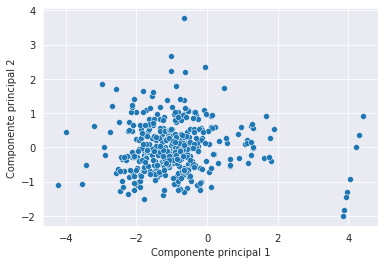

In [7]:
mi_max = [i[0] for i in pca_data]
mi_super_max = [i[1] for i in pca_data]
mi_super_avg = [i[2] for i in pca_data]

pca_df = pd.DataFrame({'MI_max': mi_max, 'MI_super_max': mi_super_max, 'MI_super_avg': mi_super_avg})

plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
sns.scatterplot(data=pca_df.sample(500), x='MI_max', y='MI_super_max')
plt.show()

Clusterização com MI_max e MI_super_max

## Aplicação de escala

In [8]:
scaler = StandardScaler()

df_columns = dropped_df.columns
scaled_df = pd.DataFrame(scaler.fit_transform(dropped_df), columns=df_columns)

scaled_df.describe()

,MI_max,MI_super_max,MI_super_avg
count,3.026345e+06,3.026345e+06,3.026345e+06
mean,-5.090907e-16,2.067805e-16,1.748215e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.140347e+00,-8.570364e-01,-5.286827e-01
25%,-7.785712e-01,-5.568342e-01,-3.122516e-01
50%,-1.815175e-01,-1.965915e-01,-1.885767e-01
75%,5.539835e-01,2.236917e-01,2.785443e-02
max,8.394794e+00,6.999069e+01,1.083671e+02


## Clusterização

In [9]:
pca_train = pca_df[['MI_max','MI_super_max', 'MI_super_avg']].values

scaler = StandardScaler().fit(pca_train)

pca_transformed = scaler.transform(pca_train)

transformed_df = pd.DataFrame(data=pca_transformed, columns=[['MI_max','MI_super_max', 'MI_super_avg']], index=[i for i in range(len(pca_transformed))])

transformed_df.describe()

,MI_max,MI_super_max,MI_super_avg
count,3.026345e+06,3.026345e+06,3.026345e+06
mean,-1.110067e-17,-2.930126e-18,-1.682944e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585896e+00,-4.314245e+00,-4.608137e+00
25%,-6.430950e-01,-6.262074e-01,-5.238525e-01
50%,-3.948139e-01,3.279070e-02,1.488456e-01
75%,1.783191e-01,4.192876e-01,4.669774e-01
max,3.138035e+00,1.211968e+01,1.517278e+01


In [10]:
## Salvando transformed_df para análise aplicação de índices paralelos

transformed_df.to_csv('./cluster-results/transformed_df.tsv', sep='\t')

In [11]:
kmeans = MiniBatchKMeans(n_clusters=3).fit(transformed_df[['MI_max','MI_super_max']].values)

labeled_df = pd.DataFrame({ 
  'Max direct influence': list(map(lambda x: x[0], transformed_df['MI_max'].values)), 
  'Max indirect influence': list(map(lambda x: x[0], transformed_df['MI_super_max'].values)),
  'Avg indirect influence': list(map(lambda x: x[0], transformed_df['MI_super_avg'].values)),
  'Labels': list(map(lambda x: str(x), kmeans.labels_))
})
labeled_df.head(10)

,Max direct influence,Max indirect influence,Avg indirect influence,Labels
0,1.927917,0.032791,0.148846,1
1,0.224086,1.044656,1.387057,2
2,0.264219,0.560018,1.352578,2
3,0.242821,0.356928,1.432166,2
4,0.242821,0.356928,1.432166,2
5,0.242821,0.356928,1.432166,2
6,0.242821,0.356928,1.432166,2
7,0.242821,0.356928,1.432166,2
8,0.242821,0.356928,1.432166,2
9,0.242821,0.356928,1.432166,2


<AxesSubplot:xlabel='Componente principal 1', ylabel='Componente principal 2'>

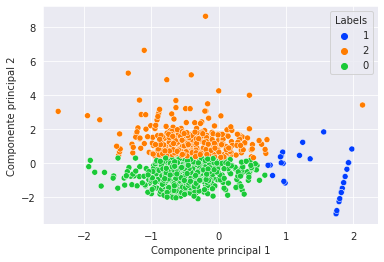

In [22]:
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
sns.scatterplot(data=labeled_df.sample(1500), x='Max direct influence', y='Max indirect influence', hue='Labels', palette='bright')

In [23]:
dropped_df['labels'] = list(map(lambda x: str(x), kmeans.labels_))

cluster = []

for x in ["0", "1", "2"]:
    cluster.append(labeled_df.query('Labels == "%s"' % x))

In [24]:
dropped_df.query('labels == "0"').describe()

,MI_max,MI_super_max,MI_super_avg
count,1.598911e+06,1.598911e+06,1.598911e+06
mean,4.428237e+00,7.159359e-02,1.741195e-02
std,2.014060e+00,5.622463e-02,1.531595e-02
min,1.209000e+00,1.000000e-03,0.000000e+00
25%,2.911000e+00,4.000000e-02,1.000000e-02
50%,3.932000e+00,5.500000e-02,1.300000e-02
75%,5.472000e+00,8.200000e-02,1.900000e-02
max,2.059900e+01,9.740000e-01,2.400000e-01


In [25]:
dropped_df.query('labels == "1"').describe()

,MI_max,MI_super_max,MI_super_avg
count,599671.000000,599671.000000,599671.000000
mean,0.366318,0.018675,0.011280
std,1.485236,0.093456,0.059411
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,23.141000,4.530000,3.380000


In [26]:
dropped_df.query('labels == "2"').describe()

,MI_max,MI_super_max,MI_super_avg
count,827763.000000,827763.000000,827763.000000
mean,1.299245,0.056931,0.020710
std,0.663490,0.048149,0.027866
min,0.000000,0.000000,0.000000
25%,0.850000,0.030000,0.010000
50%,1.348000,0.045000,0.014000
75%,1.762000,0.073000,0.023000
max,5.824000,4.720000,3.522000


In [27]:
means = pd.DataFrame(columns=[
    'Max direct influence',
    'Max indirect influence',
    'Avg indirect influence'
])

for frame in range(len(cluster)):
    description = cluster[frame].describe()
    
    new_row = pd.DataFrame({
        'Max direct influence': [description['Max direct influence'].iloc[1]],
        'Max indirect influence': [description['Max indirect influence'].iloc[1]],
        'Avg indirect influence': [description['Avg indirect influence'].iloc[1]],
        'Label': [str(frame)]
    })
    
    means = pd.concat([means, new_row], ignore_index=True)
    
means

,Max direct influence,Max indirect influence,Avg indirect influence,Label
0,-0.487049,-0.595666,-0.06555,0
1,1.874777,-0.062591,0.174639,1
2,-0.417392,1.195935,0.0001,2


In [28]:
from math import pi


def make_spider(row, title, color):

    # number of variable
    categories=list(means)[0:3]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,3,row+1, polar=True, )
    plt.tight_layout()

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([-5,-2.5, 0, 2.5, 5], ['-5','-2,5','0', '2,5', '5'], color="grey", size=7)
    plt.ylim(-5, 5)

    # Ind1
    values=means.loc[row].drop('Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

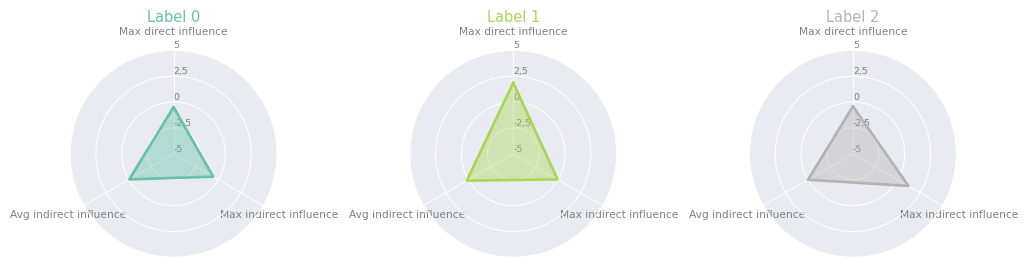

In [29]:
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(means.index))
# Loop to plot
for row in range(0, len(means.index)):
    make_spider( row=row, title='Label '+str(row), color=my_palette(row))

In [30]:
df['labels'] = dropped_df['labels']

df.to_csv('./cluster-results/labeled_df.tsv', sep='\t')
df.head(10)

,index,MI_max,MI_super_max,MI_super_avg,user,group,timestamp,labels
0,0,0.000,0.000,0.000,561401894,561401894--1001034598292,1.544316e+09,1
1,1,1.127,0.067,0.066,561401894,561401894--1001034598292,1.551133e+09,2
2,2,1.529,0.078,0.071,561401894,561401894--1001034598292,1.552320e+09,2
3,3,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
4,4,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
5,5,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
6,6,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
7,7,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
8,8,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
9,9,1.778,0.077,0.070,561401894,561401894--1001034598292,1.552358e+09,2
